MAgent repo: https://github.com/PettingZoo-Team/MAgent

Installment:  pip install magent

In [1]:
import magent
from MAgent.examples.models import buffer

In [2]:
from magent.gridworld import Config   #used to cutomise gridworld env

In [3]:
import torch
import numpy as np
import math
import time
import argparse

import matplotlib.pyplot as plt

# setting up env ('pursuit')

In [4]:
map_size = 50
env_name = "pursuit"
env = magent.GridWorld(env_name, map_size=map_size)    #setup pursuit env
env.reset()                                             #reset env , i.e. agent group
handles = env.get_handles()                             #list of agent groups, which contains 'predator' and 'prey' in pursuit game


"""
Default config of env:

Env name      |     handles     |  handles setting
-----------------------------------------------------------------------------------------------------------------------------------------------------------
pursuit       | [predator,prey] | predator{'width': 2, 'length': 2, 'hp': 1, 'speed': 1, 'view_range': 5, 'attack range': 2, 'attack penality':-0.2}
              |                 | prey    {'width': 1, 'length': 1, 'hp': 1, 'speed': 1.5,'view range': 4, 'attack range':0}
-----------------------------------------------------------------------------------------------------------------------------------------------------------
battle        | [army1, army2]  | army: {width': 1, 'length': 1, 'hp': 10, 'speed': 2, 'view range':6,'attack range':1.5, 'damage': 2
-----------------------------------------------------------------------------------------------------------------------------------------------------------
double attack | [deer, tiger]   | deer{'width': 1, 'length': 1, 'hp': 5, 'speed': 1,'view range':1, 'attack range':0}
              |                 | tiger{'width': 1, 'length': 1, 'hp': 10, 'speed': 1, 'view range':4, 'attack range':1}
-----------------------------------------------------------------------------------------------------------------------------------------------------------
forest        | [deer, tiger]   | deer{'width': 1, 'length': 1, 'hp': 5, 'speed': 1,'view range':1, 'attack range':0}
              |                 | tiger{'width': 1, 'length': 1, 'hp': 10, 'speed': 1, 'view range':4, 'attack range':1}
-----------------------------------------------------------------------------------------------------------------------------------------------------------

One may also customise the env sertting by sending Config: env = magent.GridWorld(config)
and defining own reward fn :
----------------------------------------------------------------
a = AgentSymbol(tiger_group, index='any')
b = AgentSymbol(tiger_group, index='any')
c = AgentSymbol(deer_group,  index='any')

# tigers get reward when they attack a deer simultaneously
e1 = Event(a, 'attack', c)
e2 = Event(b, 'attack', c)
config.add_reward_rule(e1 & e2, receiver=[a, b], value=[1, 1])
----------------------------------------------------------------



Env observation:

There are two parts in observation, spacial local view and non-spacial feature.(for detailed see https://github.com/geek-ai/MAgent/blob/master/doc/get_started.md)

Spatial view consists of several rectangular channels. These channels will be masked by a circle or a sector 
as described in the agent type registration. If the radius of a circle is 5, then the size of one channel 
is 11 x 11, where 11 = 5x2 + 1

Non-spatial feature includes ID embedding, last action, last reward and normalized position. 
ID embedding is the binary representation of agent's unique ID.


Env action:
Actions are discrete actions. They can be move, attack and turn


"""
print('')
#some config of env





In [5]:
env.reset()                                             #reset env , i.e. agent group
handles = env.get_handles()  



#One can get access to the env setting by
view_space = env.view_space             #what the agents see, (partially-obsersed env)
feature_space = env.feature_space       #information embedding
action_space = env.action_space         #how the agents act
print('Env info:')
print('view space: {};\nfeature space: {};\naction space: {}\n'.format(view_space,
                                                                    feature_space,
                                                                    action_space))
#or the setting for each agent group individually by
view_space1, view_space2 = env.get_view_space(handles[0]),env.get_view_space(handles[1])
featuer_space1, feature_space2 = env.get_feature_space(handles[0]), env.get_feature_space(handles[1])
action_space1, action_space2 = env.get_action_space(handles[0]), env.get_action_space(handles[1])





#then one can start adding agent to each agent group(handle) by
num_agents = 15
env.add_agents(handles[0], method = 'random', n = num_agents)    
         #add num_agents number of agents randomly to the env and assign them to group handles[0]
         #one can aslo customise the postion (see fn generate_map() )
env.add_agents(handles[1], method = 'random', n = num_agents)           #one can also add obstacle such as walls
        
predator_num, prey_num = env.get_num(handles[0]), env.get_num(handles[1])     #ask for the size of each agent group
print('Agent group size:')
print('Number of predators: {}; Number of preys: {}\n'.format(predator_num, prey_num))

predator_ids, prey_ids = env.get_agent_id(handles[0]), env.get_agent_id(handles[1]) #ask for the agent id list






#Once agents have beed added, one can ask for the detailed info of each single agent at current state by
predator_position, prey_position = env.get_pos(handles[0]), env.get_pos(handles[1])   #[agent_num, 2]

predator_view, predator_feature = env.get_observation(handles[0])   #[num_agent, view_space/feature_space]
prey_view, prey_feature = env.get_observation(handles[1])       

predator_reward = env.get_reward(handles[0])   #(agent_num, )
prey_reward = env.get_reward(handles[1])

predator_alive, prey_alive = env.get_alive(handles[0]), env.get_alive(handles[1])

print('Agent info:')
print('predator position shape: {}; prey position shape: {}'.format(predator_position.shape, prey_position.shape))
print('predator view shape: {}; prey view shape: {}'.format(predator_view.shape, prey_view.shape))
print('predator feature shape: {}; prey feature shape: {}'.format(predator_feature.shape, prey_feature.shape))
print('predator reward shape:{}; prey reward shape:{}'.format(predator_reward.shape, prey_reward.shape))
print('predator alive shape: {}; prey alive shape: {}'.format(predator_alive.shape, prey_alive.shape))

Env info:
view space: {0: (10, 10, 5), 1: (9, 9, 5)};
feature space: {0: (14,), 1: (10,)};
action space: {0: (13,), 1: (9,)}

Agent group size:
Number of predators: 15; Number of preys: 15

Agent info:
predator position shape: (15, 2); prey position shape: (15, 2)
predator view shape: (15, 10, 10, 5); prey view shape: (15, 9, 9, 5)
predator feature shape: (15, 14); prey feature shape: (15, 10)
predator reward shape:(15,); prey reward shape:(15,)
predator alive shape: (15,); prey alive shape: (15,)


In [6]:
def generate_map(env, map_size, handles):
    """ customise a map, which consists of two squares of agents"""
    width = height = map_size
    init_num = map_size * map_size * 0.04
    gap = 3

    # left
    n = init_num
    side = int(math.sqrt(n)) * 2
    pos = []
    for x in range(width//2 - gap - side, width//2 - gap - side + side, 2):
        for y in range((height - side)//2, (height - side)//2 + side, 2):
            pos.append([x, y, 0])
    env.add_agents(handles[0], method="custom", pos=pos)

    # right
    n = init_num
    side = int(math.sqrt(n)) * 2
    pos = []
    for x in range(width//2 + gap, width//2 + gap + side, 2):
        for y in range((height - side)//2, (height - side)//2 + side, 2):
            pos.append([x, y, 0])
    env.add_agents(handles[1], method="custom", pos=pos)

## Visualisation

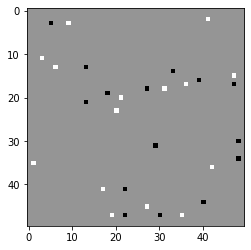

In [7]:
fig_predator = env.get_global_minimap(50,50)[:,:,0]
fig_prey = env.get_global_minimap(50,50)[:,:,1]

plt.imshow(fig_predator - fig_prey, cmap = 'Greys');   #



# A testing framework

In [8]:
print_every = 50


env.reset()  
handles = env.get_handles()
num_agents = 15
env.add_agents(handles[0], method = 'random', n = num_agents)    
env.add_agents(handles[1], method = 'random', n = num_agents)

step_ct = 0
done = False


n = len(handles)                                     #number of agent groups, 2 in this case
obs  = [[] for _ in range(n)]   #observation container
ids  = [[] for _ in range(n)]   #agent id container
acts = [[] for _ in range(n)]   #action container
nums = [env.get_num(handle) for handle in handles]   #[num of predator, num of prey]
sample_buffer = [buffer.EpisodesBuffer(capacity=1500) for _ in range(n)]

total_reward = [0 for _ in range(n)]


while not done:
    # take actions for every model
    for i in range(n):
        obs[i] = env.get_observation(handles[i])   #ask for observation, the view shape [num_agents, ...]
        ids[i] = env.get_agent_id(handles[i])       #ask for agent's id
        acts[i] =  np.int32(np.random.choice(range(env.get_action_space(handles[0])[0]), env.get_num(handles[0])))
                 #random action
        env.set_action(handles[i], acts[i])      #send the action to the env

    # simulate one step
    done = env.step()

    # sample
    step_reward = []
    for i in range(n):
        rewards = env.get_reward(handles[i])     #ask for the reawrd
        #if train:
        alives = env.get_alive(handles[i])  #ask whether the agent stay alive
        sample_buffer[i].record_step(ids[i], obs[i], acts[i], rewards, alives)
        
        s = sum(rewards)
        step_reward.append(s)
        total_reward[i] += s


    # stat info
    nums = [env.get_num(handle) for handle in handles]

    # clear dead agents
    env.clear_dead()

    if step_ct % print_every == 0:
        print("step %3d,  nums: %s reward: %s,  total_reward: %s " %
              (step_ct, nums, np.around(step_reward, 2), np.around(total_reward, 2)))
    step_ct += 1
    if step_ct > 550:
        break




step   0,  nums: [15, 15] reward: [-2.2  0. ],  total_reward: [-2.2  0. ] 
step  50,  nums: [15, 15] reward: [-1.4  0. ],  total_reward: [-86.2  -3. ] 
step 100,  nums: [15, 15] reward: [-2.  0.],  total_reward: [-177.   -5.] 
step 150,  nums: [15, 15] reward: [-2.  0.],  total_reward: [-263.4   -6. ] 
step 200,  nums: [15, 15] reward: [-1.8  0. ],  total_reward: [-352.4   -8. ] 
step 250,  nums: [15, 15] reward: [-2.4  0. ],  total_reward: [-436.4  -14. ] 
step 300,  nums: [15, 15] reward: [-1.8  0. ],  total_reward: [-522.8  -16. ] 
step 350,  nums: [15, 15] reward: [-1.  0.],  total_reward: [-603.4  -23. ] 
step 400,  nums: [15, 15] reward: [-1.8  0. ],  total_reward: [-695.6  -28. ] 
step 450,  nums: [15, 15] reward: [-2.4  0. ],  total_reward: [-790.8  -32. ] 
step 500,  nums: [15, 15] reward: [-2.2  0. ],  total_reward: [-876.2  -35. ] 
step 550,  nums: [15, 15] reward: [-2.2  0. ],  total_reward: [-960.  -42.] 


# A training framwork

### Models (DQN)

In [9]:
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical

import torch.optim as optimizer
import numpy as np

class ReplayBuffer:
    """a circular queue based on numpy array, supporting batch put and batch get"""
    def __init__(self, shape, dtype=np.float32):
        self.buffer = np.empty(shape=shape, dtype=dtype)
        self.head   = 0
        self.capacity   = len(self.buffer)

    def put(self, data):
        """put data to

        Parameters
        ----------
        data: numpy array
            data to add
        """
        head = self.head
        n = len(data)
        if head + n <= self.capacity:
            self.buffer[head:head+n] = data
            self.head = (self.head + n) % self.capacity
        else:
            split = self.capacity - head
            self.buffer[head:] = data[:split]
            self.buffer[:n - split] = data[split:]
            self.head = split
        return n

    def get(self, index):
        """get items

        Parameters
        ----------
        index: int or numpy array
            it can be any numpy supported index
        """
        return self.buffer[index]

    def clear(self):
        """clear replay buffer"""
        self.head = 0



class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

class CNN_encoder(nn.Module):
    """
    view size : [batch, 13, 13,7]
    feature size: [batch, 34]
    """
    def __init__(self):
        super(CNN_encoder, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels = 5, out_channels = 32, kernel_size = 3, stride = 2),
            nn.ReLU(),
            nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, stride = 1),
            nn.ReLU(),
            Flatten()
        )
    
    def forward(self, view_state):
        """
        [batch, 13,13,7]
        """
        state = view_state.permute(0,3,1,2)
        
        return self.net(state)  #[batch, 128]


class Critic(nn.Module):
    def __init__(self, output_size, input_size=128, hidden_size=128, feature_size = 14):
        super().__init__()
        
        self.conv = CNN_encoder()
        
        self.input_size = input_size
        self.output_size = output_size
        
        self.view_linear = nn.Linear(input_size, hidden_size)

        self.feature_linear = nn.Linear(feature_size, feature_size)
        
        self.concat_linear = nn.Sequential(
            nn.Linear(hidden_size+feature_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )
        

    def forward(self, view_state, feature_state):
        """
        view_state: [batch, 13,13,7]
        feature_state: [batch, 34]
        """
        view_encoded_state = self.view_linear(self.conv(view_state))
        view_encoded_state = F.relu(view_encoded_state)

        feature_encoded_state = F.relu(self.feature_linear(feature_state))
        
        concate = torch.cat([view_encoded_state, feature_encoded_state], dim = -1)  #[]batch, hidden+feature
        
        return self.concat_linear(concate)   #[batch, output_size]
    
        

class DQN(object):
    def __init__(self, action_dim, env, handle, memory_size):
        """
        also input env for parameter enquiry, and handle
        """


        self.action_dim = action_dim
        self.gamma = 0.99

        #self.hidden_size = args.hidden_size
        self.lr = 0.001 #args.c_lr
        #self.buffer_size = args.buffer_capacity
        #self.batch_size = args.batch_size
        #self.gamma = args.gamma
        self.batch_size = 50
        self.train_freq = 1
        
        
        self.view_space = env.get_view_space(handle)   #[13,13,7]
        self.feature_space = env.get_feature_space(handle)  #[34, ]
        self.action_space = env.get_action_space(handle)  #[21,]
        self.env = env
        self.handle = handle
        
        self.critic_eval = Critic(output_size = action_dim, feature_size = self.feature_space[0])
        self.critic_target = Critic(output_size = action_dim, feature_size = self.feature_space[0])
        self.optimizer = optimizer.Adam(self.critic_eval.parameters(), lr=self.lr)
        
        
        
        self.replay_buf_len = 0          #live recording the length of replay buffer                                                    
        self.memory_size = memory_size                                                     
        self.replay_buf_view     = ReplayBuffer(shape=(memory_size,) + self.view_space)    # (memory, 13,13,7)
        self.replay_buf_feature  = ReplayBuffer(shape=(memory_size,) + self.feature_space) 
        self.replay_buf_action   = ReplayBuffer(shape=(memory_size,), dtype=np.int32)      
        self.replay_buf_reward   = ReplayBuffer(shape=(memory_size,))                      
        self.replay_buf_terminal = ReplayBuffer(shape=(memory_size,), dtype=np.bool)       
        self.replay_buf_mask     = ReplayBuffer(shape=(memory_size,))                      
        
        

        # exploration
        #self.eps = args.epsilon
        #self.eps_end = args.epsilon_end
        #self.eps_delay = 1 / (args.max_episode * 100)

        # 更新target网
        self.learn_step_counter = 0
        self.target_replace_iter = 50#args.target_replace
        self.target_update = 1

        #trajectory_property = get_trajectory_property()
        #self.memory = buffer(self.buffer_size, trajectory_property)
        #self.memory.init_item_buffers()
        
    def choose_action(self, raw_obs, ids, greedy):
        """
        raw_obs: tuple([total_num, 13, 13, 7], [total_num, feature_size]), np array
        ids:   numpy array ,ids of agents
        greedy: if greedy, all agent act greedily, otherwise ([0,1] float) act e-greedy
        need to batchify the data 
        """
        view, feature = raw_obs[0], raw_obs[1]
        view = torch.FloatTensor(view)
        feature = torch.FloatTensor(feature)
        
        n = len(view)  #total number of data
        batch_size = min(n, self.batch_size)
        
        ret = []
        for i in range(0, n, batch_size):
            beg, end = i, i+batch_size

            ret.append(self.critic_eval(view[beg:end], feature[beg:end]).detach().cpu().numpy())
        ret = np.concatenate(ret)   #[total_num, action_dim]
        
        #sampled action
            
        greedy_action = np.argmax(ret, axis = -1)   #[total_num, ]
        
        if greedy is True:
            return np.int32(greedy_action)
        else:
            random_action = np.random.choice(range(self.action_dim), n)
            indicator = (torch.rand(n).uniform_(0,1) < greedy).float().numpy()
            
            action = greedy_action * np.abs(1-indicator) + random_action * indicator
            return np.int32(action)
            

    def add_replay_buffer(self, memory):
        
        n = 0
        for episode in memory.episodes():   #contain data for each episodic run for each single agent
            v, f, a, r = episode.views, episode.features, episode.actions, episode.rewards   
            m = len(r)   #length of the episode
            
            mask = np.ones((m,))
            terminal = np.full((m,), False)  #np.zeros((m,), dtype = np.bool)
            if episode.terminal:
                terminal[-1] = True
            else:
                mask[-1] = 0    #end the episode if its not terminated
            
            self.replay_buf_view.put(v)
            
            self.replay_buf_feature.put(f)                                                   
            self.replay_buf_action.put(a)                                                    
            self.replay_buf_reward.put(r)                                                    
            self.replay_buf_terminal.put(terminal)                                           
            self.replay_buf_mask.put(mask)  
            
            n += m
            
        self.replay_buf_len = min(self.memory_size, self.replay_buf_len + n)      #update buffer length
        
        return n

    
    def learn(self, sample_buffer):
        add_num = self.add_replay_buffer(sample_buffer)
        batch_size = self.batch_size
        total_loss = 0
        
        n_batches = int(self.train_freq * add_num / batch_size)  
        print("batch number: %d  add: %d  replay_len: %d/%d" %               
              (n_batches, add_num, self.replay_buf_len, self.memory_size))   
        
        start_time = time.time()  
        ct = 0            
        
        for i in range(n_batches):
            index = np.random.choice(self.replay_buf_len - 1, batch_size)
            
            batch_view     = torch.FloatTensor(self.replay_buf_view.get(index))             #[batch, 13,13,7]                      
            batch_feature  = torch.FloatTensor(self.replay_buf_feature.get(index))          #[batch, feature_dim]                       
            batch_action   = torch.FloatTensor((self.replay_buf_action.get(index))).unsqueeze(-1)  #[batch, 1]                                 
            batch_reward   = torch.FloatTensor(self.replay_buf_reward.get(index)).unsqueeze(-1)  #[batch, 1]                                 
            batch_terminal = self.replay_buf_terminal.get(index)                               
            batch_mask     = torch.FloatTensor(self.replay_buf_mask.get(index)).unsqueeze(-1)   
            
            batch_next_view = torch.FloatTensor(self.replay_buf_view.get(index+1))
            batch_next_feature = torch.FloatTensor(self.replay_buf_feature.get(index+1))

            batch_current_q = self.critic_eval(batch_view, batch_feature).gather(1, batch_action.long())
            batch_next_q = self.critic_target(batch_next_view, batch_next_feature).detach()
            batch_q_target = batch_reward + batch_mask * self.gamma * (batch_next_q.max(dim = -1)[0]).unsqueeze(-1)
            loss_fn = nn.MSELoss()
            loss = loss_fn(batch_current_q, batch_q_target)
            
            total_loss += loss
        
        if ct % self.target_update == 0:      
            self.optimizer.zero_grad()
            total_loss.backward()
            self.optimizer.step()
            print('Update Q')
            
        if self.learn_step_counter % self.target_replace_iter == 0:
            self.critic_target.load_state_dict(self.critic_eval.state_dict())
            print('update target Q')
        self.learn_step_counter += 1    
            

### Train (1 episode)

In [10]:



env.reset()  
handles = env.get_handles()
num_agents = 15
env.add_agents(handles[0], method = 'random', n = num_agents)    
env.add_agents(handles[1], method = 'random', n = num_agents)

step_ct = 0
done = False


n = len(handles)                                     #number of agent groups, 2 in this case
obs  = [[] for _ in range(n)]   #observation container
ids  = [[] for _ in range(n)]   #agent id container
acts = [[] for _ in range(n)]   #action container
nums = [env.get_num(handle) for handle in handles]   #[num of predator, num of prey]
sample_buffer = [buffer.EpisodesBuffer(capacity=15000) for _ in range(n)]
#sample_buffer = buffer.EpisodesBuffer(capacity=15000)
#sample_buffer2 = buffer.EpisodesBuffer(capacity=1500)
#sample_buffer = [sample_buffer1, sample_buffer2]

total_reward = [0 for _ in range(n)]

models = []
models.append(DQN(env.get_action_space(handles[0])[0], env, handles[0], 2**10))
models.append(DQN(env.get_action_space(handles[1])[0], env, handles[1], 2**10))


while not done:
    # take actions for every model
    for i in range(n):
        obs[i] = env.get_observation(handles[i])   #ask for observation, the view shape [num_agents, ...]
        ids[i] = env.get_agent_id(handles[i])       #ask for agent's id
        acts[i] = models[i].choose_action(obs[i], ids[i], 0.2)
                 #random action
        env.set_action(handles[i], acts[i])      #send the action to the env

    # simulate one step
    done = env.step()

    # sample
    step_reward = []
    for i in range(n):
        rewards = env.get_reward(handles[i])     #ask for the reawrd
        #if train:
        alives = env.get_alive(handles[i])  #ask whether the agent stay alive
        sample_buffer[i].record_step(ids[i], obs[i], acts[i], rewards, alives)
        
        s = sum(rewards)
        step_reward.append(s)
        total_reward[i] += s


    # stat info
    nums = [env.get_num(handle) for handle in handles]

    # clear dead agents
    env.clear_dead()

    if step_ct % print_every == 0:
        print("step %3d,  nums: %s reward: %s,  total_reward: %s " %
              (step_ct, nums, np.around(step_reward, 2), np.around(total_reward, 2)))
    step_ct += 1
    if step_ct > 550:
        break

for i in range(n):
    models[i].learn(sample_buffer[i])


step   0,  nums: [15, 15] reward: [0. 0.],  total_reward: [0. 0.] 


/Users/yansong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:154: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


step  50,  nums: [15, 15] reward: [-0.6  0. ],  total_reward: [-19.2  -3. ] 
step 100,  nums: [15, 15] reward: [ 1.6 -2. ],  total_reward: [-26.6 -12. ] 
step 150,  nums: [15, 15] reward: [-0.8  0. ],  total_reward: [-34.6 -22. ] 
step 200,  nums: [15, 15] reward: [-0.4  0. ],  total_reward: [-38.6 -39. ] 
step 250,  nums: [15, 15] reward: [-0.2  0. ],  total_reward: [-55.6 -42. ] 
step 300,  nums: [15, 15] reward: [0. 0.],  total_reward: [-60.8 -52. ] 
step 350,  nums: [15, 15] reward: [-0.2  0. ],  total_reward: [-65.2 -67. ] 
step 400,  nums: [15, 15] reward: [-0.4  0. ],  total_reward: [-67.8 -82. ] 
step 450,  nums: [15, 15] reward: [0. 0.],  total_reward: [-74.4 -92. ] 
step 500,  nums: [15, 15] reward: [-0.2  0. ],  total_reward: [-88.2 -95. ] 
step 550,  nums: [15, 15] reward: [-0.2  0. ],  total_reward: [ -97.8 -103. ] 
batch number: 165  add: 8265  replay_len: 1024/1024
Update Q
update target Q
batch number: 165  add: 8265  replay_len: 1024/1024
Update Q
update target Q
